# Unrolled generative adversarial networks on a toy dataset

This notebook demos a simple implementation of unrolled generative adversarial networks on a 2d mixture of Gaussians dataset. See the [paper](https://arxiv.org/abs/1611.02163) for a better description of the technique, experiments, results, and other good stuff. Note that the architecture and hyperparameters used in this notebook are not identical to the one in the paper.

In [1]:
%pylab inline
from collections import OrderedDict
import tensorflow as tf
ds = tf.contrib.distributions
slim = tf.contrib.slim
        
from keras.optimizers import Adam

try:
    from moviepy.video.io.bindings import mplfig_to_npimage
    import moviepy.editor as mpy
    generate_movie = True
except:
    print("Warning: moviepy not found.")
    generate_movie = False

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
_graph_replace = tf.contrib.graph_editor.graph_replace

def remove_original_op_attributes(graph):
    """Remove _original_op attribute from all operations in a graph."""
    for op in graph.get_operations():
        op._original_op = None
        
def graph_replace(*args, **kwargs):
    """Monkey patch graph_replace so that it works with TF 1.0"""
    remove_original_op_attributes(tf.get_default_graph())
    return _graph_replace(*args, **kwargs)

### Utility functions

In [3]:
def extract_update_dict(update_ops):
    """Extract variables and their new values from Assign and AssignAdd ops.
    
    Args:
        update_ops: list of Assign and AssignAdd ops, typically computed using Keras' opt.get_updates()

    Returns:
        dict mapping from variable values to their updated value
    """
    name_to_var = {v.name: v for v in tf.global_variables()}
    updates = OrderedDict()
    for update in update_ops:
        var_name = update.op.inputs[0].name
        var = name_to_var[var_name]
        value = update.op.inputs[1]
        if update.op.type == 'Assign':
            updates[var.value()] = value
        elif update.op.type == 'AssignAdd':
            updates[var.value()] = var + value
        else:
            raise ValueError("Update op type (%s) must be of type Assign or AssignAdd"%update_op.op.type)
    return updates

### Data creation

In [4]:
def pairwise_dist (A, B):  
  """
  Computes pairwise distances between each elements of A and each elements of B.
  Args:
    A,    [m,d] matrix
    B,    [n,d] matrix
  Returns:
    D,    [m,n] matrix of pairwise distances
  """
  with tf.variable_scope('pairwise_dist'):
    # squared norms of each row in A and B
    na = tf.reduce_sum(tf.square(A), 1)
    nb = tf.reduce_sum(tf.square(B), 1)
    
    # na as a row and nb as a co"lumn vectors
    na = tf.reshape(na, [-1, 1])
    nb = tf.reshape(nb, [1, -1])

    # return pairwise euclidead difference matrix
    D = tf.sqrt(tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 0.0))
  return D

In [5]:
def sample_mog_with_labels(batch_size, n_mixture=8, std=0.01, radius=1.0):
    thetas = np.linspace(0, 2 * np.pi, n_mixture)
    xs, ys = radius * np.sin(thetas), radius * np.cos(thetas)
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    centroids = [ (xi, yi) for xi, yi in zip(xs.ravel(), ys.ravel()) ]
    data = ds.Mixture(cat, comps)
    sample = data.sample(batch_size)
    dist = pairwise_dist(sample, centroids)
    labels_onehot = tf.one_hot(tf.nn.top_k(-dist).indices, tf.shape(dist)[1])
    #print(labels_onehot.shape)
    #print(sample.shape)
    return sample, labels_onehot

## Metrics

### Pre-trained classifier

In [6]:
n_classes = 8

In [7]:
## Basic GMM classifier

from sklearn import mixture

g = mixture.GaussianMixture(n_components=8)

def fit_classifier(x_train, y_train, sess):
  g.fit(x_train.eval(session=sess), y_train.eval(session=sess))

def classify(x_batch):
  return g.predict_proba(x_batch)

In [8]:
distr = tf.contrib.distributions

def prob_distr(img_batch):
    img_classes = classify(img_batch)
    totals = np.sum(img_classes, axis=0)
    return totals/np.sum(totals)

def kl_divergence(img_batch):
  
    #prob distr of samples
    gen_pd = prob_distr(img_batch) 
  
    # number of modes covered in samples
    modes_covered = sum(1 for p in gen_pd if p > 0) 
  
    # kl divergence
    tiny_e = 1e-5
    gen_pd_epsilon = gen_pd + tiny_e
    data_pd = np.full((n_classes,),(1/n_classes)) + tiny_e
    kl = np.sum(gen_pd_epsilon * np.log(gen_pd_epsilon / data_pd)) 
    rev_kl = np.sum(data_pd * np.log(data_pd / gen_pd_epsilon)) 
  
    return kl, rev_kl, gen_pd, modes_covered

## Generator and discriminator architectures

In [9]:
def generator(z, output_dim=2, n_hidden=128, n_layer=2):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.tanh)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=128, n_layer=2, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.tanh)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Hyperparameters

In [10]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-3,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=25000,
    viz_every=1000,
    z_dim=256,
    x_dim=2,
    unrolling_steps=0,
)

## Construct model and training ops

In [11]:
tf.reset_default_graph()

data, labels = sample_mog_with_labels(params['batch_size'])

noise = ds.Normal(tf.zeros(params['z_dim']), 
                  tf.ones(params['z_dim'])).sample(params['batch_size'])
# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.4)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

# Vanilla discriminator update
d_opt = Adam(lr=params['disc_learning_rate'], beta_1=params['beta1'], epsilon=params['epsilon'])
updates = d_opt.get_updates(disc_vars, [], loss)
d_train_op = tf.group(*updates, name="d_train_op")

# Unroll optimization of the discrimiantor
if params['unrolling_steps'] > 0:
    # Get dictionary mapping from variables to their update value after one optimization step
    update_dict = extract_update_dict(updates)
    cur_update_dict = update_dict
    for i in range(params['unrolling_steps'] - 1):
        # Compute variable updates given the previous iteration's updated variable
        cur_update_dict = graph_replace(update_dict, cur_update_dict)
    # Final unrolled loss uses the parameters at the last time step
    unrolled_loss = graph_replace(loss, cur_update_dict)
else:
    unrolled_loss = loss

# Optimize the generator on the unrolled loss
g_train_opt = tf.train.AdamOptimizer(params['gen_learning_rate'], beta1=params['beta1'], epsilon=params['epsilon'])
g_train_op = g_train_opt.minimize(-unrolled_loss, var_list=gen_vars)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updatin

## Train!

In [12]:
sess = tf.InteractiveSession()

In [13]:
sess.run(tf.global_variables_initializer())

|
--------------------------ITERATION 0/25000:
KL Div: 0.1102
Reverse KL Div: 0.2044
MC: 8


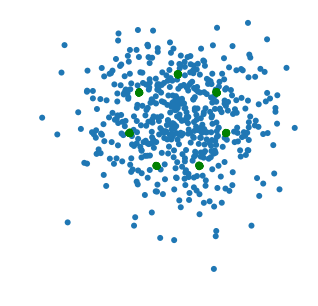

||||||||||
--------------------------ITERATION 1000/25000:
KL Div: 0.2115
Reverse KL Div: 0.2997
MC: 8


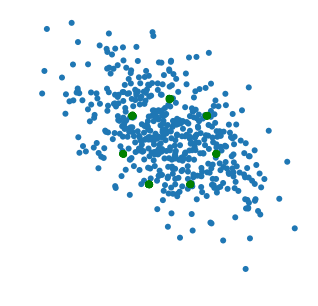

||||||||||
--------------------------ITERATION 2000/25000:
KL Div: 0.2562
Reverse KL Div: 0.2825
MC: 8


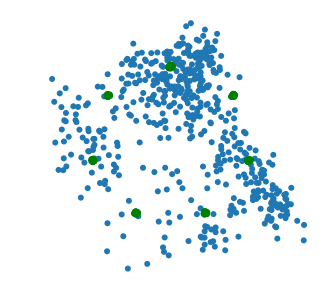

||||||||||
--------------------------ITERATION 3000/25000:
KL Div: 0.184
Reverse KL Div: 0.2712
MC: 8


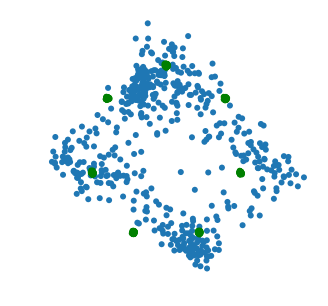

||||||||||
--------------------------ITERATION 4000/25000:
KL Div: 0.1504
Reverse KL Div: 0.2849
MC: 8


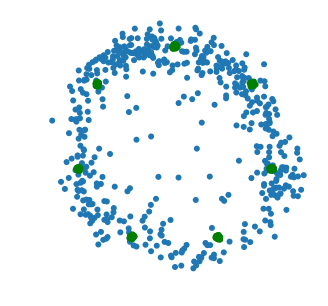

||||||||||
--------------------------ITERATION 5000/25000:
KL Div: 0.09777
Reverse KL Div: 0.1351
MC: 8


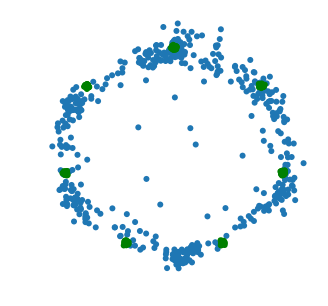

||||||||||
--------------------------ITERATION 6000/25000:
KL Div: 0.07608
Reverse KL Div: 0.07913
MC: 8


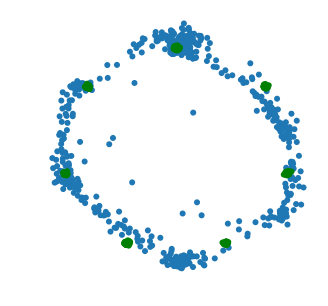

||||||||||
--------------------------ITERATION 7000/25000:
KL Div: 0.1138
Reverse KL Div: 0.1554
MC: 8


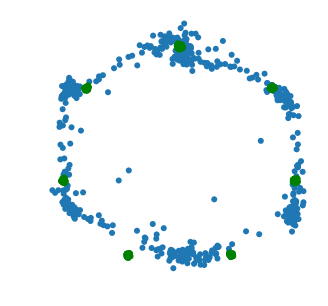

||||||||||
--------------------------ITERATION 8000/25000:
KL Div: 0.1984
Reverse KL Div: 0.24
MC: 8


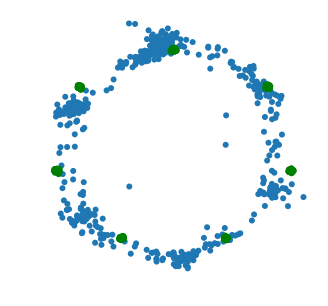

||||||||||
--------------------------ITERATION 9000/25000:
KL Div: 0.1751
Reverse KL Div: 0.2985
MC: 8


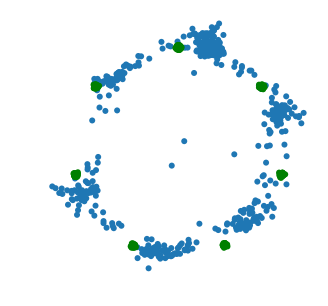

||||||||||
--------------------------ITERATION 10000/25000:
KL Div: 0.1142
Reverse KL Div: 0.1218
MC: 8


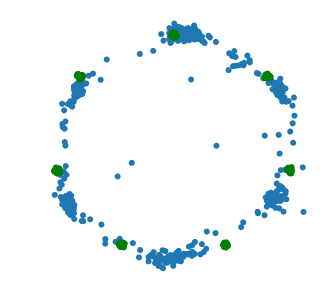

||||||||||
--------------------------ITERATION 11000/25000:
KL Div: 1.471
Reverse KL Div: 6.752
MC: 3


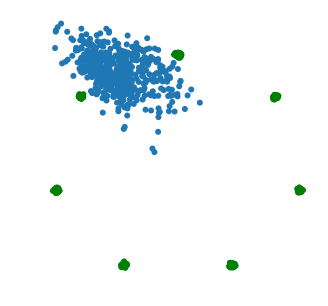

||||||||||
--------------------------ITERATION 12000/25000:
KL Div: 1.496
Reverse KL Div: 5.049
MC: 6


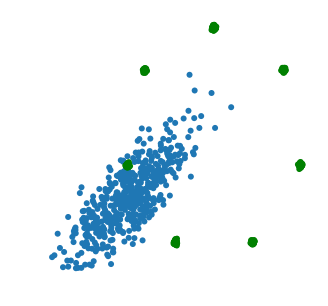

||||||||||
--------------------------ITERATION 13000/25000:
KL Div: 0.4863
Reverse KL Div: 0.7417
MC: 8


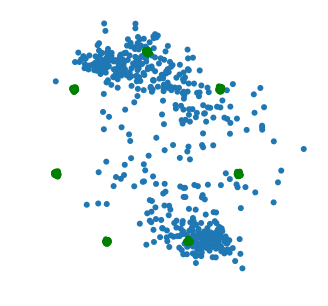

||||||||||
--------------------------ITERATION 14000/25000:
KL Div: 0.6672
Reverse KL Div: 2.645
MC: 7


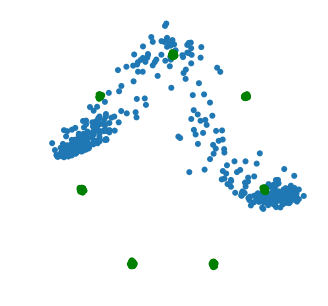

||||||||||
--------------------------ITERATION 15000/25000:
KL Div: 0.8689
Reverse KL Div: 2.838
MC: 6


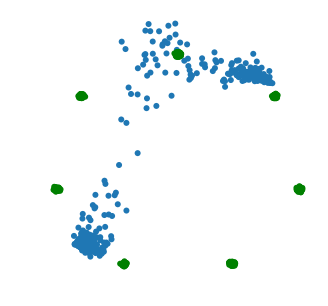

||||||||||
--------------------------ITERATION 16000/25000:
KL Div: 0.8152
Reverse KL Div: 2.636
MC: 6


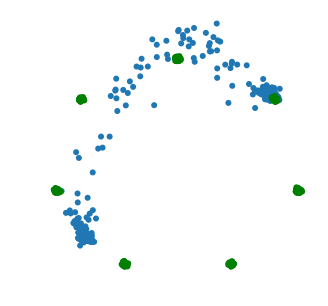

||||||||||
--------------------------ITERATION 17000/25000:
KL Div: 1.058
Reverse KL Div: 3.864
MC: 5


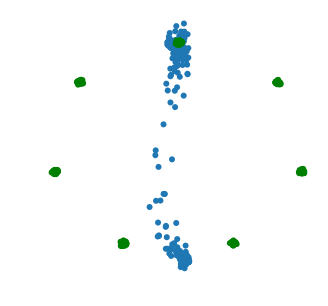

||||||||||
--------------------------ITERATION 18000/25000:
KL Div: 1.108
Reverse KL Div: 3.902
MC: 5


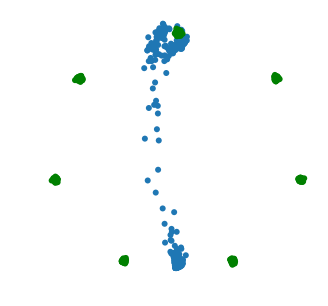

||||||||||
--------------------------ITERATION 19000/25000:
KL Div: 1.135
Reverse KL Div: 4.078
MC: 5


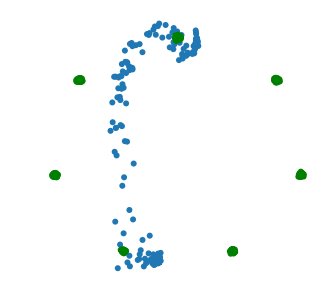

||||||||||
--------------------------ITERATION 20000/25000:
KL Div: 0.8994
Reverse KL Div: 2.802
MC: 6


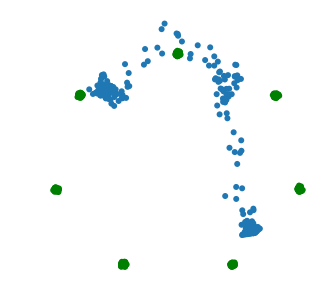

||||||||||
--------------------------ITERATION 21000/25000:
KL Div: 1.016
Reverse KL Div: 3.008
MC: 6


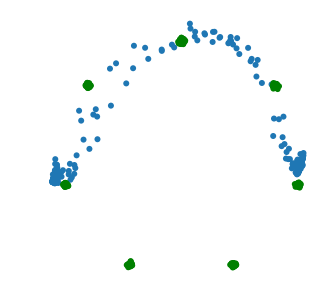

||||||||||
--------------------------ITERATION 22000/25000:
KL Div: 0.7998
Reverse KL Div: 2.67
MC: 6


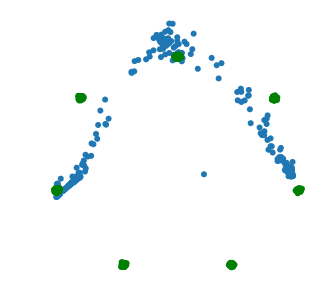

||||||||||
--------------------------ITERATION 23000/25000:
KL Div: 0.5158
Reverse KL Div: 2.354
MC: 7


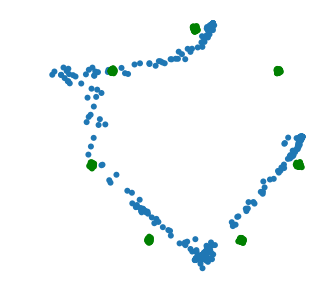

||||||||||
--------------------------ITERATION 24000/25000:
KL Div: 1.071
Reverse KL Div: 3.844
MC: 6


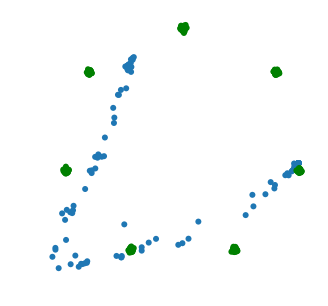

|||||||||
--------------------------ITERATION 24999/25000:
KL Div: 0.9751
Reverse KL Div: 3.742
MC: 5


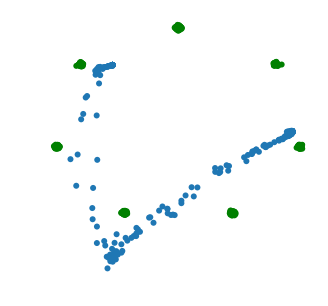

In [14]:
#prepare
fit_classifier(data, labels, sess)

xmax = 3
n_batches_viz = 10
run = 1

fs = []
frames = []
np_samples = []
kls, rev_kls, pds, mcs = [], [], [], []

viz_every = params['viz_every']

for i in range(params['max_iter']):
    
    # tracking
    if (i % 100 == 0):
        print('|', end='')
    
    # training step
    f, _, _ = sess.run([[loss, unrolled_loss], g_train_op, d_train_op])
    
    # record
    fs.append(f)
    
    # every nth sample, take some measurements and visualize
    if (i % viz_every == 0) or (i == params['max_iter']-1):
      
        print('\n--------------------------ITERATION %d/%d:'%(i, params['max_iter']))
        
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        
        # get metrics
        kl, rev_kl, pd, mc = kl_divergence(xx)

        # print
        print('KL Div: {:.4}'.format(kl))
        print('Reverse KL Div: {:.4}'.format(rev_kl))
        print('MC: {}'.format(mc))

        # save
        kls.append(kl)
        rev_kls.append(rev_kl)
        pds.append(pd)
        mcs.append(mc)
        
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], edgecolor='none')
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none')
        axis('off')
        if generate_movie:
            frames.append(mplfig_to_npimage(fig))
        plt.savefig('/mnt/p/toy_run_converge/{}.png'.format(str(i).zfill(2)))
        show()

In [15]:
run_summary = np.concatenate([kls, rev_kls, mcs]).reshape(3, int(params['max_iter']/viz_every)+1 ).T
np.savetxt('/mnt/p/toy_run_converge/metrics_D{}_G{}.csv'.format(run, params['disc_learning_rate'], params['gen_learning_rate']), run_summary, fmt='%1.4e', delimiter=',', header="KLDivergence,RevKLDivergence,ModesCovered")
np.savetxt('/mnt/p/toy_run_converge/prob_distr.csv'.format(run), pds, fmt='%1.4e', delimiter=',')

In [16]:
#import seaborn as sns
from scipy.stats import kde

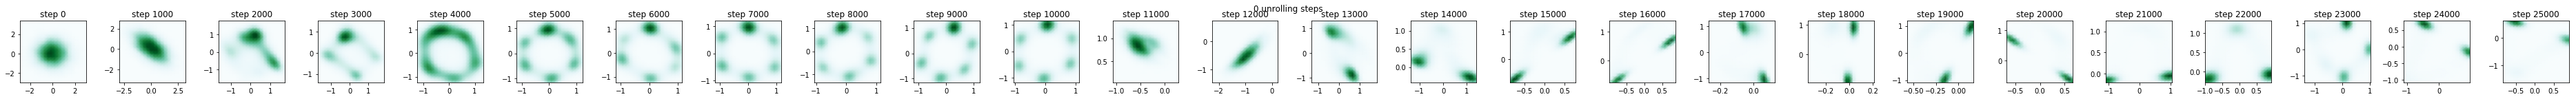

In [17]:
np_samples_ = np_samples[::1]
cols = len(np_samples_)
#bg_color  = sns.color_palette('Greens', n_colors=256)[0]
fig = figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        ax = subplot(1,cols,i+1) #sharex=ax, sharey=ax)
    
    #create gaussian kde
    nbins=20
    x, y = samps.T
    k = kde.gaussian_kde(samps.T)
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn)
    ax.set_title('step %d'%(i*viz_every))
    
suptitle('%d unrolling steps'%params['unrolling_steps'])
gcf().tight_layout()

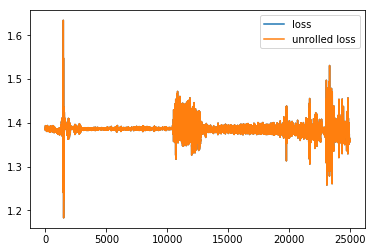

In [18]:
fs = np.array(fs)
plot(fs)
legend(('loss', 'unrolled loss'))